**Домашнее задание №8 (вообще вроде 7)**

## Imports

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.8.0


In [2]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
# from IPython.display import Image
# from IPython.core.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.metrics import classification_report

In [6]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"
# !pip install datasets
from datasets import load_dataset

In [7]:
import re

# Задание 1 (4 балла)

Обучите 2 модели похожую по архитектуре на модель из ULMFit для задачи классификации текста (датасет - lenta_40k )
В моделях должно быть как минимум два рекуррентных слоя, а финальный вектор для классификации составляться из последнего состояния RNN (так делалось в семинаре), а также AveragePooling и MaxPooling из всех векторов последовательности (конкатенируйте последнее состояния и результаты пулинга). В первой модели используйте обычные слои, а во второй Bidirectional. Рассчитайте по классовую точность/полноту/f-меру для каждой из модели (результаты не должны быть совсем близкие к нулю после обучения на хотя бы нескольких эпохах).

## Data

In [ ]:
!wget 'https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/data/lenta_40k.csv.zip'

In [ ]:
!unzip 'lenta_40k.csv.zip'

In [ ]:
data = pd.read_csv('lenta_40k.csv.zip')

In [ ]:
data.head(5)

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия


## Preprocessing

In [ ]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [ ]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [ ]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [ ]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [ ]:
MAX_LEN = max(len(x) for x in X)
MEAN_LEN = np.median([len(x) for x in X])

MAX_LEN, MEAN_LEN

(1748, 170.0)

In [ ]:
MAX_LEN = int(MEAN_LEN + 30)

In [ ]:
# паддинг
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [ ]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [ ]:
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

In [ ]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
id2label

{0: 'Бизнес',
 1: 'Бывший СССР',
 2: 'Библиотека',
 3: 'Легпром',
 4: 'Из жизни',
 5: 'Культура',
 6: 'Спорт',
 7: 'Культпросвет ',
 8: 'Россия',
 9: 'Интернет и СМИ',
 10: 'Мир',
 11: 'Экономика',
 12: 'Путешествия',
 13: '69-я параллель',
 14: 'Силовые структуры',
 15: 'Крым',
 16: 'Наука и техника',
 17: 'Ценности',
 18: 'Дом'}

## Model #1

- минимум два рекуррентных слоя
- финальный вектор для классификации составляться из
  - последнего состояния RNN (так делалось в семинаре)
  - AveragePooling и MaxPooling из всех векторов последовательности (конкатенируйте последнее состояние и результаты пулинга)
- обычные слои (unidirectional)

### Compiling

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = keras.layers.SimpleRNN(64, return_sequences=True)(embeddings)
rnn2 = keras.layers.LSTM(64, return_sequences=True)(rnn)

pool1 = keras.layers.GlobalAveragePooling1D()(rnn2)
pool2 = keras.layers.GlobalMaxPooling1D()(rnn2)

concat = keras.layers.concatenate((rnn2[:, -1, :], pool1, pool2,), axis=1)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(concat)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_11 (Embedding)  │ (None, 200, 30)        │        722,790 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ simple_rnn_11 (SimpleRNN) │ (None, 200, 64)        │          6,080 │ embedding_11[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_11 (LSTM)            │ (None, 200, 64)        │         33,024 │ simple_rnn_11[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 64)             │              0 │ lstm_11[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 64)             │              0 │ lstm_11[0][0]          │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_2    │ (None, 64)             │              0 │ lstm_11[0][0]          │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 192)            │              0 │ get_item_1[0][0],      │
│ (Concatenate)             │                        │                │ global_average_poolin… │
│                           │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 19)             │          3,667 │ concatenate_5[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 765,561 (2.92 MB)

 Trainable params: 765,561 (2.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_rec@prec',
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=5, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1,
                                              mode='max',
                                              )
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', # названия файла
                                                monitor='val_rec@prec', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

### Fitting

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2000,
          epochs=20,
          callbacks=[checkpoint, early_stop])

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - loss: 2.7026 - rec@prec: 1.2987e-05
Epoch 1: val_rec@prec improved from 0.00000 to 0.00045, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 464ms/step - loss: 2.6957 - rec@prec: 1.2422e-05 - val_loss: 2.3528 - val_rec@prec: 4.5086e-04
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - loss: 2.2904 - rec@prec: 8.2731e-05
Epoch 2: val_rec@prec did not improve from 0.00045
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 478ms/step - loss: 2.2887 - rec@prec: 8.3261e-05 - val_loss: 2.1758 - val_rec@prec: 0.0000e+00
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - loss: 2.0570 - rec@prec: 1.8772e-04
Epoch 3: val_rec@prec did not improve from 0.00045
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 437ms/step - loss: 2.0542 - rec@prec: 1.8059e-04 - val_loss: 1.8870 - val_rec@prec: 4.5086e-04
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - loss: 1.7995 - rec@prec: 0.0015
Epoch 4: val_rec@prec improved from 0.00045 to 0.01398, saving model to mod

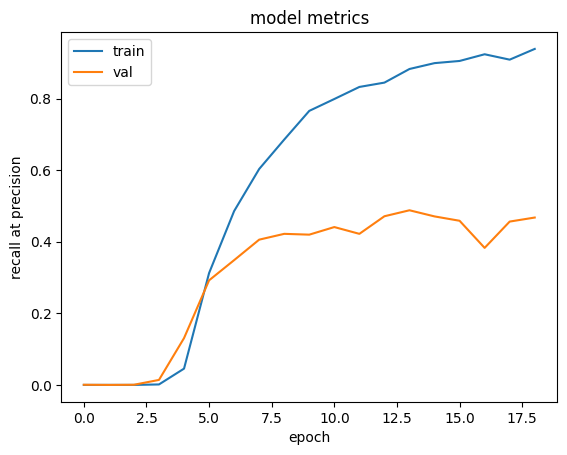

In [ ]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [ ]:
pred = model.predict(X_valid).argmax(1)

70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 260ms/step


In [ ]:
print(classification_report(y_valid.argmax(1).reshape(-1), pred.reshape(-1), labels=list(id2label.keys()),
                                                                     target_names=list(id2label.values()),
                                                                     zero_division=0))

                   precision    recall  f1-score   support

           Бизнес       0.29      0.09      0.14        22
      Бывший СССР       0.58      0.58      0.58       159
       Библиотека       0.00      0.00      0.00         0
          Легпром       0.00      0.00      0.00         0
         Из жизни       0.22      0.20      0.21        84
         Культура       0.78      0.63      0.69       159
            Спорт       0.93      0.91      0.92       195
    Культпросвет        0.00      0.00      0.00         1
           Россия       0.73      0.66      0.69       481
   Интернет и СМИ       0.38      0.46      0.41       132
              Мир       0.64      0.74      0.69       410
        Экономика       0.74      0.72      0.73       239
      Путешествия       0.12      0.05      0.07        21
   69-я параллель       0.00      0.00      0.00         4
Силовые структуры       0.15      0.17      0.16        60
             Крым       0.00      0.00      0.00       

## Model #2

- минимум два рекуррентных слоя
- финальный вектор для классификации составляться из
  - последнего состояния RNN (так делалось в семинаре)
  - AveragePooling и MaxPooling из всех векторов последовательности (конкатенируйте последнее состояние и результаты пулинга)
- Bidirectional слои (отличие)

### Compiling

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True))(embeddings)
rnn2 = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True))(rnn)

pool1 = keras.layers.GlobalAveragePooling1D()(rnn2)
pool2 = keras.layers.GlobalMaxPooling1D()(rnn2)

concat = keras.layers.concatenate((rnn2[:, -1, :], pool1, pool2,), axis=1)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(concat)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24            │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_24 (Embedding)  │ (None, 200, 30)        │        722,790 │ input_layer_24[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_18          │ (None, 200, 128)       │         48,640 │ embedding_24[0][0]     │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_19          │ (None, 200, 128)       │         98,816 │ bidirectional_18[0][0] │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_11 (GetItem)     │ (None, 128)            │              0 │ bidirectional_19[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ bidirectional_19[0][0] │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_13   │ (None, 128)            │              0 │ bidirectional_19[0][0] │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_16            │ (None, 384)            │              0 │ get_item_11[0][0],     │
│ (Concatenate)             │                        │                │ global_average_poolin… │
│                           │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 19)             │          7,315 │ concatenate_16[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 877,561 (3.35 MB)

 Trainable params: 877,561 (3.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_rec@prec',
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=5, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1,
                                              mode='max',
                                              )
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', # названия файла
                                                monitor='val_rec@prec', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

### Fitting

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2000,
          epochs=10,
          callbacks=[checkpoint, early_stop])

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.3915 - rec@prec: 0.0000e+00
Epoch 1: val_rec@prec improved from -inf to 0.00000, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 2.3899 - rec@prec: 0.0000e+00 - val_loss: 2.2891 - val_rec@prec: 0.0000e+00
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.1884 - rec@prec: 3.7879e-06
Epoch 2: val_rec@prec did not improve from 0.00000
22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 2.1848 - rec@prec: 3.6232e-06 - val_loss: 1.9790 - val_rec@prec: 0.0000e+00
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.9276 - rec@prec: 1.5152e-06
Epoch 3: val_rec@prec improved from 0.00000 to 0.00135, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - loss: 1.9261 - rec@prec: 1.4493e-06 - val_loss: 1.8549 - val_rec@prec: 0.0014
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.7531 - rec@prec: 0.0170
Epoch 4: val_rec@prec improved from 0.00135 to 0.13571, saving mo

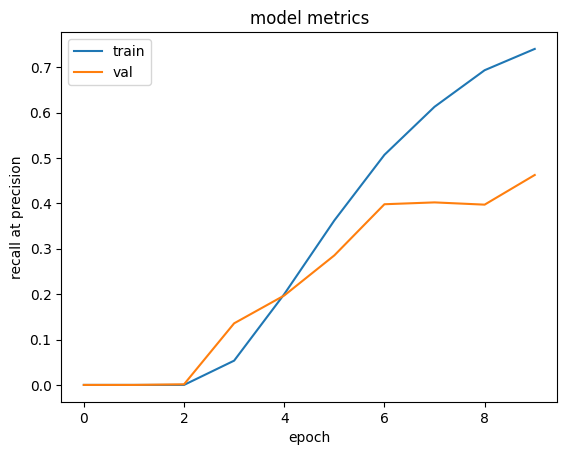

In [ ]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [ ]:
pred = model.predict(X_valid).argmax(1)

70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 552ms/step


In [ ]:
print(classification_report(y_valid.argmax(1).reshape(-1), pred.reshape(-1), labels=list(id2label.keys()),
                                                                     target_names=list(id2label.values()),
                                                                     zero_division=0))

                   precision    recall  f1-score   support

           Бизнес       0.00      0.00      0.00        22
      Бывший СССР       0.76      0.38      0.51       159
       Библиотека       0.00      0.00      0.00         0
          Легпром       0.00      0.00      0.00         0
         Из жизни       0.20      0.20      0.20        84
         Культура       0.83      0.70      0.76       159
            Спорт       0.97      0.87      0.92       195
    Культпросвет        0.00      0.00      0.00         1
           Россия       0.54      0.74      0.62       481
   Интернет и СМИ       0.26      0.38      0.31       132
              Мир       0.67      0.70      0.69       410
        Экономика       0.75      0.76      0.76       239
      Путешествия       0.00      0.00      0.00        21
   69-я параллель       0.00      0.00      0.00         4
Силовые структуры       0.00      0.00      0.00        60
             Крым       0.00      0.00      0.00       

# Задание 2 (6 баллов)


*Задача: sequence labelling*

На данных википедии (wikiann) обучите и сравните 3 модели:  
1. модель в которой как минимум два рекуррентных слоя, причем один из них GRU, а другой LSTM
2. модель в которой как минимум 3 рекуррентных слоя идут друг за другом и при этом 2-ой и 3-й слои еще имеют residual connection к изначальным эмбедингам. Для того, чтобы сделать residual connection вам нужно будет использовать одинаковую размерность эмбедингов и количество unit'ов в RNN слоях, чтобы их можно было просуммировать
3. модель в которой будут и рекуррентные, и сверточные слои (как минимум 2 rnn и как минимум 2 cnn слоя). В cnn слоях будьте аккуратны с укорачиванием последовательности и используйте паддинг



Сравните качество по метрикам (точность/полнота/f-мера). Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

## Data

In [8]:
dataset = load_dataset("wikiann", 'ru')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/158k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/809k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/816k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [9]:
dataset

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 20000
    })
})

## Preprocessing

In [10]:
# словарь
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

In [11]:
# тут словарь не очень большой и тут нужно предсказывать тэги для всех слов
# поэтому не будем фильтровать словарь
len(vocab)

36015

In [12]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

In [13]:
id2word = {i:word for word, i in word2id.items()}

In [14]:
# переводим тексты в последовательности индексов
X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [15]:
# переводим тексты в последовательности индексов
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [16]:
MAX_LEN = max(len(x) for x in X)

# паддинг
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

In [72]:
'''
Теги уже переведены в индексы, но обратный маппинг мы тоже сделаем,
чтобы дальше удобнее было проверять работу модели. Длина последовательностей
тегов должна совпадать с длиной последовательностей токенов, поэтому тут тоже
нужно сделать паддинг, но в этом случае мы не можем паддить нулями,
т.к. ноль у нас уже забронирован тэгом O. Добавим дополнительный тэг пад
и будем использовать его индекс при паддинге (value=7)
'''

label2id = {
    "B-LOC": 0,
    "B-ORG": 1,
    "B-PER": 2,
    "I-LOC": 3,
    "I-ORG": 4,
    "I-PER": 5,
    "O": 6,
    "PAD": 7
}
id2label = {v:k for k,v in label2id.items()}

In [18]:
y = keras.preprocessing.sequence.pad_sequences(dataset['train']['ner_tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = keras.preprocessing.sequence.pad_sequences(dataset['test']['ner_tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

In [19]:
# Схема задачи, чтобы было понятнее, что мы предсказываем:
X.shape, X_test.shape

((20000, 54), (10000, 54))

In [20]:
y.shape, y_test.shape

((20000, 54), (10000, 54))

## Tools for inference

*Справка из семинара*

**PER, ORG, LOC** - это типы именованных сущностей, Person, Organization и Location. Это стандартные типы сущностей, которые чаще всего приходится выделять. Оценочные датасеты обычно размечены этими типами. Другие популярные сущности - номера телефонов, числа, имейлы, дата, время, но их обычно определяют правилами (регулярками например).

**I, B** - эта часть тэга показывает в какой части именованной сущности находится токен. **B - beggining** (начало), **I - inside** (внутри, т.е. после начала).

**O** - это отрицательный класс (outside или other), т.е. несущность.

Такую разметку назвают IOB, она помогает точнее определять сущности и различать рядом стоящие сущности одного типа. Есть и другие типы (например, BILOU - L означает last, последний токен в сущности, а U - unit, сущность из 1 токена).

In [ ]:
def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(keras.preprocessing.sequence.pad_sequences([ids],
                                                                       maxlen=max_len,
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))

    return list(zip(tokens, labels))

In [ ]:
ex1 = 'Группа комапаний "РЕНОВА" заявила о готовности поддержать номинацию "Лучший проект развития и продвижения территорий".'
ex2 = 'В прошлом году группа комапаний «ЛитРес» провела опрос среди читателей: насколько популярен в современном мире Ф. М. Достоевский.'
ex3 = 'Группа комапаний Broco начала свою деятельность с апреля 2008 года и за этот период уже открыты представительства во многих городах России.'
ex4 = 'Группа комапаний "РИК" выражает свою признательность и безграничную благодарность Ивану Ивановичу за стойкость и веру в победу...'
# примеры из интернета

## Model #1

- минимум два рекуррентных слоя, причем один из них GRU, а другой LSTM

### Compiling

In [66]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=64)(inputs, )

rnn = keras.layers.LSTM(64, return_sequences=True)(embeddings)
rnn2 = keras.layers.GRU(64, return_sequences=True)(rnn)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(rnn2)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [67]:
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 54)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_16 (Embedding)             │ (None, 54, 64)              │       2,305,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 54, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_16 (GRU)                         │ (None, 54, 64)              │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 54, 8)               │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,363,592 (9.02 MB)

 Trainable params: 2,363,592 (9.02 MB)

 Non-trainable params: 0 (0.00 B)

### Fitting

In [96]:
model.fit(X, y,
          validation_data=(X_test, y_test),
          batch_size=128,
          epochs=3)
# я поставил три эпохи, потосу что видно, что уже на третьей accuracy огромное,
# дальше вероятен только оверфит и лишнее вычисление

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 251ms/step - accuracy: 0.9805 - loss: 0.0555 - val_accuracy: 0.9714 - val_loss: 0.0837
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 198ms/step - accuracy: 0.9900 - loss: 0.0338 - val_accuracy: 0.9718 - val_loss: 0.0863
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 240ms/step - accuracy: 0.9935 - loss: 0.0207 - val_accuracy: 0.9733 - val_loss: 0.0905


In [ ]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


# не понимаю почему: ни с keras.metrics.RecallAtPrecision(0.8, name='rec@prec'),
# ни с набором 'precision', 'recall', 'f1_score' иодель не обучается, выдаёт
# разные ошибки размерностей (в зависимости от размерностей в слоях), напирмер:
# RuntimeError: The size of tensor a (6912) must match the size of
# tensor b (55296) at non-singleton dimension 1
# поэтому здесь только accuracy, но репорт ниже показывает все три метрики

### Evaluation

In [97]:
pred = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 106ms/step


In [98]:
pred.shape

(10000, 54, 8)

In [99]:
pred.argmax(2).shape

(10000, 54)

In [100]:
y_test.shape

(10000, 54)

In [101]:
print(classification_report(y_test.reshape(-1),
                            pred.argmax(2).reshape(-1),
                            labels=list(id2label.keys()),
                            target_names=list(id2label.values()),
                            zero_division=0))
# видно, что в некоторых классах f1 совсем не безупречный

              precision    recall  f1-score   support

       B-LOC       0.90      0.90      0.90     40480
       B-ORG       0.52      0.70      0.60      3542
       B-PER       0.89      0.60      0.72      7544
       I-LOC       0.56      0.58      0.57      4074
       I-ORG       0.73      0.77      0.75      8008
       I-PER       0.50      0.63      0.56      4560
           O       0.76      0.60      0.67      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.97    540000
   macro avg       0.73      0.72      0.72    540000
weighted avg       0.97      0.97      0.97    540000



### Inference

In [113]:
label_seq(ex1, word2id, id2label, MAX_LEN, model)
# организацию выделил

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


[('Группа', 'B-LOC'),
 ('комапаний', 'I-LOC'),
 ('"', 'I-ORG'),
 ('РЕНОВА', 'I-ORG'),
 ('"', 'B-LOC'),
 ('заявила', 'B-LOC'),
 ('о', 'B-LOC'),
 ('готовности', 'B-LOC'),
 ('поддержать', 'B-LOC'),
 ('номинацию', 'B-LOC'),
 ('"', 'B-LOC'),
 ('Лучший', 'B-LOC'),
 ('проект', 'B-LOC'),
 ('развития', 'B-LOC'),
 ('и', 'B-LOC'),
 ('продвижения', 'B-LOC'),
 ('территорий', 'B-LOC'),
 ('".', 'B-LOC')]

In [114]:
label_seq(ex2, word2id, id2label, MAX_LEN, model)
# организацию и персону пропустил

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


[('В', 'B-LOC'),
 ('прошлом', 'B-LOC'),
 ('году', 'I-LOC'),
 ('группа', 'B-LOC'),
 ('комапаний', 'B-LOC'),
 ('«', 'B-LOC'),
 ('ЛитРес', 'B-LOC'),
 ('»', 'I-ORG'),
 ('провела', 'B-LOC'),
 ('опрос', 'B-LOC'),
 ('среди', 'B-LOC'),
 ('читателей', 'B-LOC'),
 (':', 'I-LOC'),
 ('насколько', 'I-ORG'),
 ('популярен', 'I-ORG'),
 ('в', 'B-LOC'),
 ('современном', 'B-LOC'),
 ('мире', 'B-LOC'),
 ('Ф', 'B-LOC'),
 ('.', 'B-LOC'),
 ('М', 'B-LOC'),
 ('.', 'B-LOC'),
 ('Достоевский', 'PAD'),
 ('.', 'B-LOC')]

In [115]:
label_seq(ex3, word2id, id2label, MAX_LEN, model)
# организацию выделил, название страны -- явно не персона

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


[('Группа', 'B-LOC'),
 ('комапаний', 'I-LOC'),
 ('Broco', 'I-ORG'),
 ('начала', 'B-LOC'),
 ('свою', 'B-LOC'),
 ('деятельность', 'B-LOC'),
 ('с', 'B-LOC'),
 ('апреля', 'B-LOC'),
 ('2008', 'I-LOC'),
 ('года', 'I-ORG'),
 ('и', 'B-LOC'),
 ('за', 'B-LOC'),
 ('этот', 'B-LOC'),
 ('период', 'B-LOC'),
 ('уже', 'B-LOC'),
 ('открыты', 'B-LOC'),
 ('представительства', 'B-LOC'),
 ('во', 'B-LOC'),
 ('многих', 'B-LOC'),
 ('городах', 'B-LOC'),
 ('России', 'B-LOC'),
 ('.', 'B-LOC')]

In [116]:
label_seq(ex4, word2id, id2label, MAX_LEN, model)
# орагнизацию выделил, персону нет

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


[('Группа', 'B-LOC'),
 ('комапаний', 'I-LOC'),
 ('"', 'I-ORG'),
 ('РИК', 'I-ORG'),
 ('"', 'PAD'),
 ('выражает', 'B-LOC'),
 ('свою', 'B-LOC'),
 ('признательность', 'B-LOC'),
 ('и', 'B-LOC'),
 ('безграничную', 'B-LOC'),
 ('благодарность', 'B-LOC'),
 ('Ивану', 'B-LOC'),
 ('Ивановичу', 'B-LOC'),
 ('за', 'B-LOC'),
 ('стойкость', 'B-LOC'),
 ('и', 'B-LOC'),
 ('веру', 'B-LOC'),
 ('в', 'B-LOC'),
 ('победу', 'B-LOC'),
 ('...', 'B-LOC')]

## Model #2

- минимум 3 рекуррентных слоя идут друг за другом и при этом 2-ой и 3-й слои еще имеют residual connection к изначальным эмбедингам

### Compiling

In [102]:
fixed_len = 64 # чтобы везде одна

inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id),
                                    output_dim=fixed_len)(inputs, )

rnn1 = keras.layers.SimpleRNN(fixed_len, return_sequences=True)(embeddings)

rnn2 = keras.layers.SimpleRNN(fixed_len, return_sequences=True)(rnn1)
concat1 = keras.layers.concatenate((rnn2, embeddings))

rnn3 = keras.layers.SimpleRNN(fixed_len, return_sequences=True)(concat1)
concat2 = keras.layers.concatenate((rnn3, embeddings))

rnn4 = keras.layers.SimpleRNN(fixed_len, return_sequences=True)(concat2)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(rnn4)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [103]:
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17            │ (None, 54)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_17 (Embedding)  │ (None, 54, 64)         │      2,305,088 │ input_layer_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ simple_rnn (SimpleRNN)    │ (None, 54, 64)         │          8,256 │ embedding_17[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ simple_rnn_1 (SimpleRNN)  │ (None, 54, 64)         │          8,256 │ simple_rnn[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 54, 128)        │              0 │ simple_rnn_1[0][0],    │
│                           │                        │                │ embedding_17[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ simple_rnn_2 (SimpleRNN)  │ (None, 54, 64)         │         12,352 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 54, 128)        │              0 │ simple_rnn_2[0][0],    │
│ (Concatenate)             │                        │                │ embedding_17[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ simple_rnn_3 (SimpleRNN)  │ (None, 54, 64)         │         12,352 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 54, 8)          │            520 │ simple_rnn_3[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,346,824 (8.95 MB)

 Trainable params: 2,346,824 (8.95 MB)

 Non-trainable params: 0 (0.00 B)

### Fitting

In [104]:
model.fit(X, y,
          validation_data=(X_test, y_test),
          batch_size=128,
          epochs=3)
# я поставил три эпохи, потосу что видно, что уже на третьей accuracy огромное,
# дальше вероятен только оверфит и лишнее вычисление

# хотя на графике видно, что accuracy на валидационном не идеальное

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 37s 233ms/step - accuracy: 0.8819 - loss: 0.4002 - val_accuracy: 0.9601 - val_loss: 0.1293
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 222ms/step - accuracy: 0.9688 - loss: 0.1004 - val_accuracy: 0.9744 - val_loss: 0.0801
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 223ms/step - accuracy: 0.9881 - loss: 0.0441 - val_accuracy: 0.9775 - val_loss: 0.0698


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


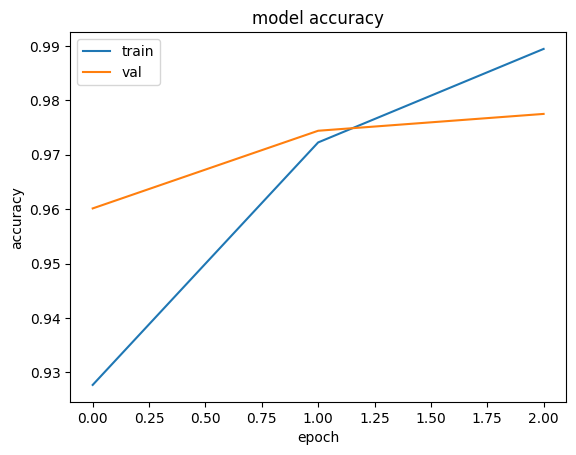

In [105]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# оставляю от первой модели, не проверял здесь, но, наверняка, будет то же самое

# не понимаю почему: ни с keras.metrics.RecallAtPrecision(0.8, name='rec@prec'),
# ни с набором 'precision', 'recall', 'f1_score' иодель не обучается, выдаёт
# разные ошибки размерностей (в зависимости от размерностей в слоях), напирмер:
# RuntimeError: The size of tensor a (6912) must match the size of
# tensor b (55296) at non-singleton dimension 1
# поэтому здесь только accuracy, но репорт ниже показывает все три метрики

### Evaluation

In [106]:
pred = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 107ms/step


In [107]:
pred.shape

(10000, 54, 8)

In [108]:
pred.argmax(2).shape

(10000, 54)

In [109]:
y_test.shape

(10000, 54)

In [110]:
print(classification_report(y_test.reshape(-1),
                            pred.argmax(2).reshape(-1),
                            labels=list(id2label.keys()),
                            target_names=list(id2label.values()),
                            zero_division=0))
# видно, что в некоторых классах f1 совсем не безупречный
# сопоставимо с первой моделью

              precision    recall  f1-score   support

       B-LOC       0.91      0.93      0.92     40480
       B-ORG       0.68      0.42      0.52      3542
       B-PER       0.89      0.90      0.89      7544
       I-LOC       0.41      0.65      0.51      4074
       I-ORG       0.75      0.78      0.77      8008
       I-PER       0.79      0.52      0.62      4560
           O       0.86      0.65      0.74      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.79      0.73      0.75    540000
weighted avg       0.98      0.98      0.98    540000



### Inference

In [117]:
label_seq(ex1, word2id, id2label, MAX_LEN, model)
# организацию выделил
# основная проблема -- вместо "ничего" ставит метки "локация"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


[('Группа', 'B-LOC'),
 ('комапаний', 'I-LOC'),
 ('"', 'I-ORG'),
 ('РЕНОВА', 'I-ORG'),
 ('"', 'B-LOC'),
 ('заявила', 'B-LOC'),
 ('о', 'B-LOC'),
 ('готовности', 'B-LOC'),
 ('поддержать', 'B-LOC'),
 ('номинацию', 'B-LOC'),
 ('"', 'B-LOC'),
 ('Лучший', 'B-LOC'),
 ('проект', 'B-LOC'),
 ('развития', 'B-LOC'),
 ('и', 'B-LOC'),
 ('продвижения', 'B-LOC'),
 ('территорий', 'B-LOC'),
 ('".', 'B-LOC')]

In [118]:
label_seq(ex2, word2id, id2label, MAX_LEN, model)
# организацию и персону пропустил

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


[('В', 'B-LOC'),
 ('прошлом', 'B-LOC'),
 ('году', 'I-LOC'),
 ('группа', 'B-LOC'),
 ('комапаний', 'B-LOC'),
 ('«', 'B-LOC'),
 ('ЛитРес', 'B-LOC'),
 ('»', 'I-ORG'),
 ('провела', 'B-LOC'),
 ('опрос', 'B-LOC'),
 ('среди', 'B-LOC'),
 ('читателей', 'B-LOC'),
 (':', 'I-LOC'),
 ('насколько', 'I-ORG'),
 ('популярен', 'I-ORG'),
 ('в', 'B-LOC'),
 ('современном', 'B-LOC'),
 ('мире', 'B-LOC'),
 ('Ф', 'B-LOC'),
 ('.', 'B-LOC'),
 ('М', 'B-LOC'),
 ('.', 'B-LOC'),
 ('Достоевский', 'PAD'),
 ('.', 'B-LOC')]

In [119]:
label_seq(ex3, word2id, id2label, MAX_LEN, model)
# организацию выделил, название страны -- явно не персона

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


[('Группа', 'B-LOC'),
 ('комапаний', 'I-LOC'),
 ('Broco', 'I-ORG'),
 ('начала', 'B-LOC'),
 ('свою', 'B-LOC'),
 ('деятельность', 'B-LOC'),
 ('с', 'B-LOC'),
 ('апреля', 'B-LOC'),
 ('2008', 'I-LOC'),
 ('года', 'I-ORG'),
 ('и', 'B-LOC'),
 ('за', 'B-LOC'),
 ('этот', 'B-LOC'),
 ('период', 'B-LOC'),
 ('уже', 'B-LOC'),
 ('открыты', 'B-LOC'),
 ('представительства', 'B-LOC'),
 ('во', 'B-LOC'),
 ('многих', 'B-LOC'),
 ('городах', 'B-LOC'),
 ('России', 'B-LOC'),
 ('.', 'B-LOC')]

In [120]:
label_seq(ex4, word2id, id2label, MAX_LEN, model)
# орагнизацию выделил, персону нет
# в целом аналогично первой модели

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


[('Группа', 'B-LOC'),
 ('комапаний', 'I-LOC'),
 ('"', 'I-ORG'),
 ('РИК', 'I-ORG'),
 ('"', 'PAD'),
 ('выражает', 'B-LOC'),
 ('свою', 'B-LOC'),
 ('признательность', 'B-LOC'),
 ('и', 'B-LOC'),
 ('безграничную', 'B-LOC'),
 ('благодарность', 'B-LOC'),
 ('Ивану', 'B-LOC'),
 ('Ивановичу', 'B-LOC'),
 ('за', 'B-LOC'),
 ('стойкость', 'B-LOC'),
 ('и', 'B-LOC'),
 ('веру', 'B-LOC'),
 ('в', 'B-LOC'),
 ('победу', 'B-LOC'),
 ('...', 'B-LOC')]

## Model #3

- как минимум 2 rnn и как минимум 2 cnn слоя

### Compiling

In [131]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id),
                                    output_dim=fixed_len)(inputs, )

rnn1 = keras.layers.SimpleRNN(32, return_sequences=True)(embeddings)
rnn2 = keras.layers.SimpleRNN(64, return_sequences=True)(rnn1)

conv1 = keras.layers.Conv1D(kernel_size=2, filters=64, strides=1,
                            activation='relu', padding='same')(rnn2)
conv2 = keras.layers.Conv1D(kernel_size=2, filters=32, strides=1,
                            activation='relu', padding='same')(conv1)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(conv2)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [132]:
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)          │ (None, 54)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_22 (Embedding)             │ (None, 54, 64)              │       2,305,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_12 (SimpleRNN)            │ (None, 54, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_13 (SimpleRNN)            │ (None, 54, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 54, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 54, 32)              │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 54, 8)               │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,327,048 (8.88 MB)

 Trainable params: 2,327,048 (8.88 MB)

 Non-trainable params: 0 (0.00 B)

### Fitting

In [133]:
model.fit(X, y,
          validation_data=(X_test, y_test),
          batch_size=128,
          epochs=3)
# я поставил три эпохи, потосу что видно, что уже на третьей accuracy огромное,
# дальше вероятен только оверфит и лишнее вычисление

# хотя на графике видно, что accuracy на валидационном не идеальное

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.8248 - loss: 0.5680 - val_accuracy: 0.9550 - val_loss: 0.1339
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.9645 - loss: 0.1027 - val_accuracy: 0.9782 - val_loss: 0.0662
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.9891 - loss: 0.0332 - val_accuracy: 0.9823 - val_loss: 0.0605


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


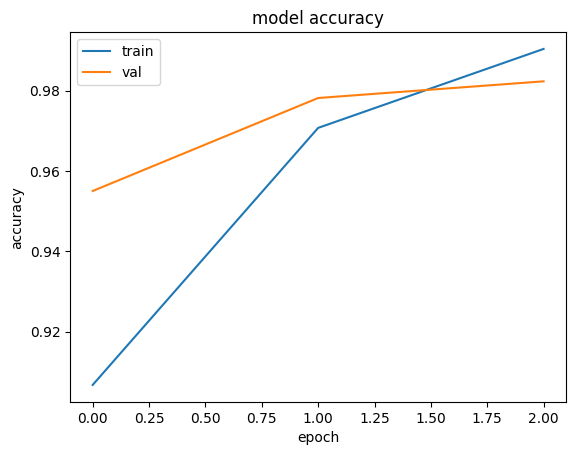

In [134]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# оставляю от первой модели, не проверял здесь, но, наверняка, будет то же самое

# не понимаю почему: ни с keras.metrics.RecallAtPrecision(0.8, name='rec@prec'),
# ни с набором 'precision', 'recall', 'f1_score' иодель не обучается, выдаёт
# разные ошибки размерностей (в зависимости от размерностей в слоях), напирмер:
# RuntimeError: The size of tensor a (6912) must match the size of
# tensor b (55296) at non-singleton dimension 1
# поэтому здесь только accuracy, но репорт ниже показывает все три метрики

### Evaluation

In [135]:
pred = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step


In [136]:
pred.shape

(10000, 54, 8)

In [137]:
pred.argmax(2).shape

(10000, 54)

In [138]:
y_test.shape

(10000, 54)

In [139]:
print(classification_report(y_test.reshape(-1),
                            pred.argmax(2).reshape(-1),
                            labels=list(id2label.keys()),
                            target_names=list(id2label.values()),
                            zero_division=0))
# видно, что в некоторых классах f1 совсем не безупречный
# сопоставимо с первыми двумя моделями, но avg повыше

              precision    recall  f1-score   support

       B-LOC       0.92      0.95      0.93     40480
       B-ORG       0.82      0.83      0.82      3542
       B-PER       0.88      0.91      0.89      7544
       I-LOC       0.72      0.55      0.62      4074
       I-ORG       0.82      0.71      0.76      8008
       I-PER       0.67      0.74      0.70      4560
           O       0.75      0.72      0.73      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.82      0.80      0.81    540000
weighted avg       0.98      0.98      0.98    540000



### Inference

In [140]:
label_seq(ex1, word2id, id2label, MAX_LEN, model)
# организацию выделил
# основная проблема -- вместо "ничего" ставит метки "локация"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


[('Группа', 'B-LOC'),
 ('комапаний', 'I-ORG'),
 ('"', 'I-ORG'),
 ('РЕНОВА', 'I-ORG'),
 ('"', 'I-ORG'),
 ('заявила', 'B-LOC'),
 ('о', 'B-LOC'),
 ('готовности', 'B-LOC'),
 ('поддержать', 'B-LOC'),
 ('номинацию', 'B-LOC'),
 ('"', 'B-LOC'),
 ('Лучший', 'B-LOC'),
 ('проект', 'B-LOC'),
 ('развития', 'B-LOC'),
 ('и', 'B-LOC'),
 ('продвижения', 'B-LOC'),
 ('территорий', 'B-LOC'),
 ('".', 'B-LOC')]

In [141]:
label_seq(ex2, word2id, id2label, MAX_LEN, model)
# организацию и персону пропустил

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[('В', 'B-LOC'),
 ('прошлом', 'I-LOC'),
 ('году', 'I-ORG'),
 ('группа', 'B-LOC'),
 ('комапаний', 'B-LOC'),
 ('«', 'B-LOC'),
 ('ЛитРес', 'I-LOC'),
 ('»', 'B-LOC'),
 ('провела', 'B-LOC'),
 ('опрос', 'B-LOC'),
 ('среди', 'B-LOC'),
 ('читателей', 'B-LOC'),
 (':', 'I-LOC'),
 ('насколько', 'I-ORG'),
 ('популярен', 'B-LOC'),
 ('в', 'B-LOC'),
 ('современном', 'B-LOC'),
 ('мире', 'B-LOC'),
 ('Ф', 'B-LOC'),
 ('.', 'B-LOC'),
 ('М', 'B-LOC'),
 ('.', 'B-LOC'),
 ('Достоевский', 'B-LOC'),
 ('.', 'B-LOC')]

In [142]:
label_seq(ex3, word2id, id2label, MAX_LEN, model)
# организацию выделил, название страны -- явно не персона

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


[('Группа', 'B-LOC'),
 ('комапаний', 'I-LOC'),
 ('Broco', 'I-ORG'),
 ('начала', 'B-LOC'),
 ('свою', 'B-LOC'),
 ('деятельность', 'B-LOC'),
 ('с', 'B-LOC'),
 ('апреля', 'I-LOC'),
 ('2008', 'I-ORG'),
 ('года', 'I-ORG'),
 ('и', 'B-LOC'),
 ('за', 'B-LOC'),
 ('этот', 'B-LOC'),
 ('период', 'B-LOC'),
 ('уже', 'B-LOC'),
 ('открыты', 'B-LOC'),
 ('представительства', 'B-LOC'),
 ('во', 'B-LOC'),
 ('многих', 'B-LOC'),
 ('городах', 'B-LOC'),
 ('России', 'I-PER'),
 ('.', 'B-LOC')]

In [143]:
label_seq(ex4, word2id, id2label, MAX_LEN, model)
# орагнизацию не выделил, персону тоже
# в целом аналогично первыс двуя моделям

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[('Группа', 'B-LOC'),
 ('комапаний', 'I-ORG'),
 ('"', 'I-ORG'),
 ('РИК', 'O'),
 ('"', 'B-PER'),
 ('выражает', 'B-LOC'),
 ('свою', 'B-LOC'),
 ('признательность', 'B-LOC'),
 ('и', 'B-LOC'),
 ('безграничную', 'B-LOC'),
 ('благодарность', 'B-LOC'),
 ('Ивану', 'B-LOC'),
 ('Ивановичу', 'B-LOC'),
 ('за', 'B-LOC'),
 ('стойкость', 'B-LOC'),
 ('и', 'B-LOC'),
 ('веру', 'B-LOC'),
 ('в', 'B-LOC'),
 ('победу', 'B-LOC'),
 ('...', 'B-LOC')]

По среднему качеству третья модель лучше всего. Есть некоторые отличия по конкретным случаям. Существенно, что на инференсе большинство токенов помечается как локация, что ненормально